# B-AMA protocol for TS forecasting using Machine Learning

B-AMA (Basic dAta-driven Models for All), is an easy, flexible, and fully coded Python-written protocol for the application of data-driven models (DDM) in hydrological problems. The protocol, has been realized with the idea of allowing students and researchers, with a basic background in programming, to develop DDM ensuring that no stones are left unturned through their implementation. B-AMA embeds data splitting, feature selection, model architecture and hyperparameter optimization, trend analysis, and performance metrics. Visualization tools are also available for the effective investigation and communication of modeling results.

## Import libraries

First, we need to import the necessary libraries and tools. (🚨 in order to run the code like in the box below, place the mouse pointer in the cell, then click on “run cell” button above or press shift + enter)

In [1]:
import numpy as np
import configparser
import dill
import os

#### Tools from the B-AMA protocol

In [2]:
import protocol.ivs as ivs
import protocol.data_division as dd
import protocol.data_transformation as dt
import protocol.model_training as mt
import protocol.model_testing as mte
import protocol.utils as ut
import protocol.postprocess as pp

# Define initial options

Second, we need to specify the case study name, the time series periodicity, the time span, and the model we want to use.

In [3]:
case_study = 'Nord'
period = 12
start = 2015
end = 2019
model = 'svm'

## Import data

Then, we can call the data reader function which, using the case study name, points to the input folder and stores the multivariate time series in a numpy array

In [4]:
xi = ut.read_model_data(case_study, period)[0, 0]

## Run the protocol steps

Once the preprocessing steps are implemented and the models configuration specified, it is time to run each individual protocol step to perform the forecast.

#### Data division and transformation

First, we split the data into training and test set, using the maximisation between sets similarity as a splitting criteria. Subsequently, we transform the data, normalizing between [0, 1].

In [5]:
# Define split index (si) and number of periodicities in the test set (n_v)
si, n_v = dd.data_division().optimal_split(xi, period, 0)

In [6]:
# Split between training (c) and test (v) set 
c, v = dd.data_division().split(xi, si, period, n_v)

In [7]:
# Generate a normalized training (cn) and test (vn) set. 
# Save the normalization parameters, which are the minimum (mn) and maximum (mX) of each column in the training set
cn, vn, mn, mX = dt.data_transformation().transform_data(c, v, period)
print(mn)
print(mX)

[-1.00000000e+00 -1.00000000e+00  1.30662021e-02  1.30662021e-02
  3.69822485e-04  3.69822485e-04  2.80649038e-01  2.80649038e-01
  1.98840726e-01  1.98840726e-01  2.67857143e-01  2.67857143e-01
  6.37019231e-02  6.37019231e-02  1.54868767e-01  1.54868767e-01
  1.13650200e+03]
[1.00000000e+00 1.00000000e+00 1.11130444e+02 1.11130444e+02
 1.36556953e+02 1.36556953e+02 1.36308894e+02 1.36308894e+02
 1.25707913e+02 1.25707913e+02 1.71462202e+02 1.71462202e+02
 2.49919471e+02 2.49919471e+02 1.39928214e+02 1.39928214e+02
 6.26229200e+03]


#### Input variable selection

To remove redundant information and select the most informative input, we run a model based input variable selection routine called forward selection. The routine returns the index of the columns (in the order they are stored in the input .csv file) selected to run the model. 
Being the forward selection an iterative procedure, we can also visualize the sequential order into which the predictors are selected, toghether with the accuracy improvement the selection brings into the model.

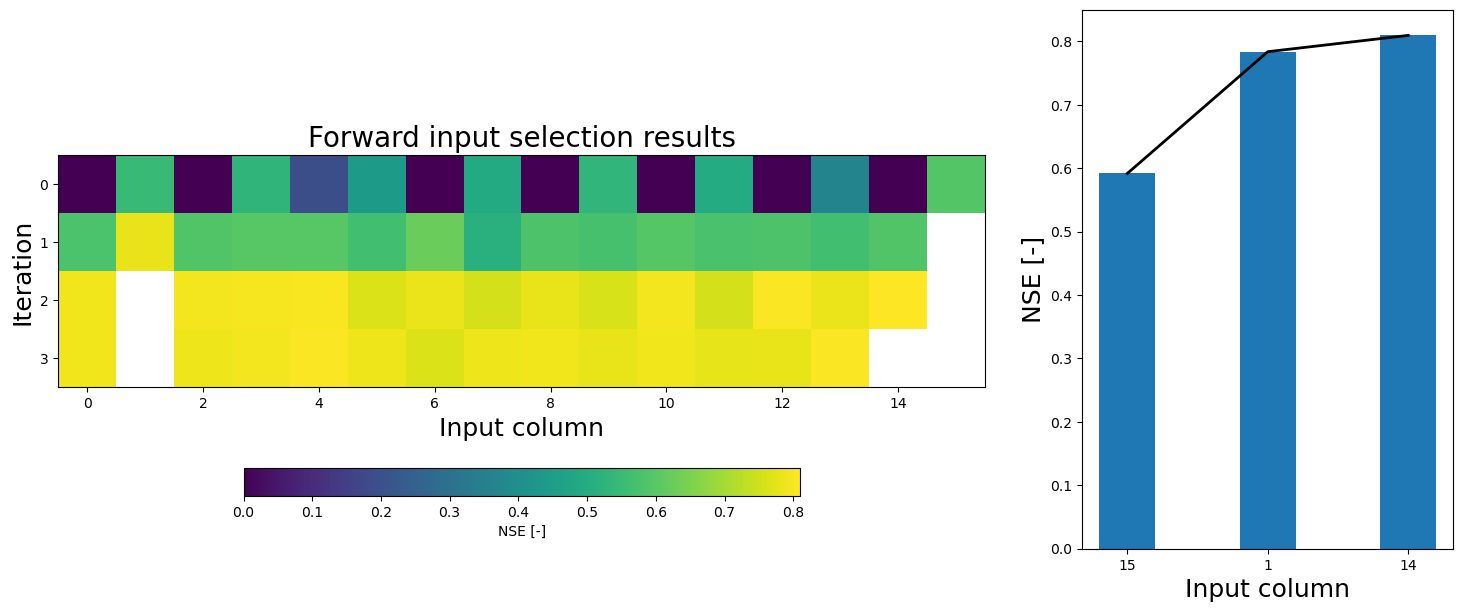

In [8]:
column_index = ivs.input_variable_selection().select_input(cn, case_study)

In [9]:
print(column_index)

[15, 1, 14]


As we can see above, the input variable selection algorithm extracted columns 15, 1 and 14 as predictors. Therefore, out of the fifteen initial candidates, only three will be used to train the model. 

#### Model training

Once the relevant predictors are selected, it is time to determine the optimal modeling structure and the optimal value of the hyperparameters. This is done through a k-fold crossvalidation procedure, (based on sequential splits on the training set), with the objective of minimizing the root mean squared error in the cross-validation set.
Here, we can also visualize how the tuning parameters shape the objective function value.
The routine returns a model object (ms), which includes the optimal architectures and hyperparameter values.

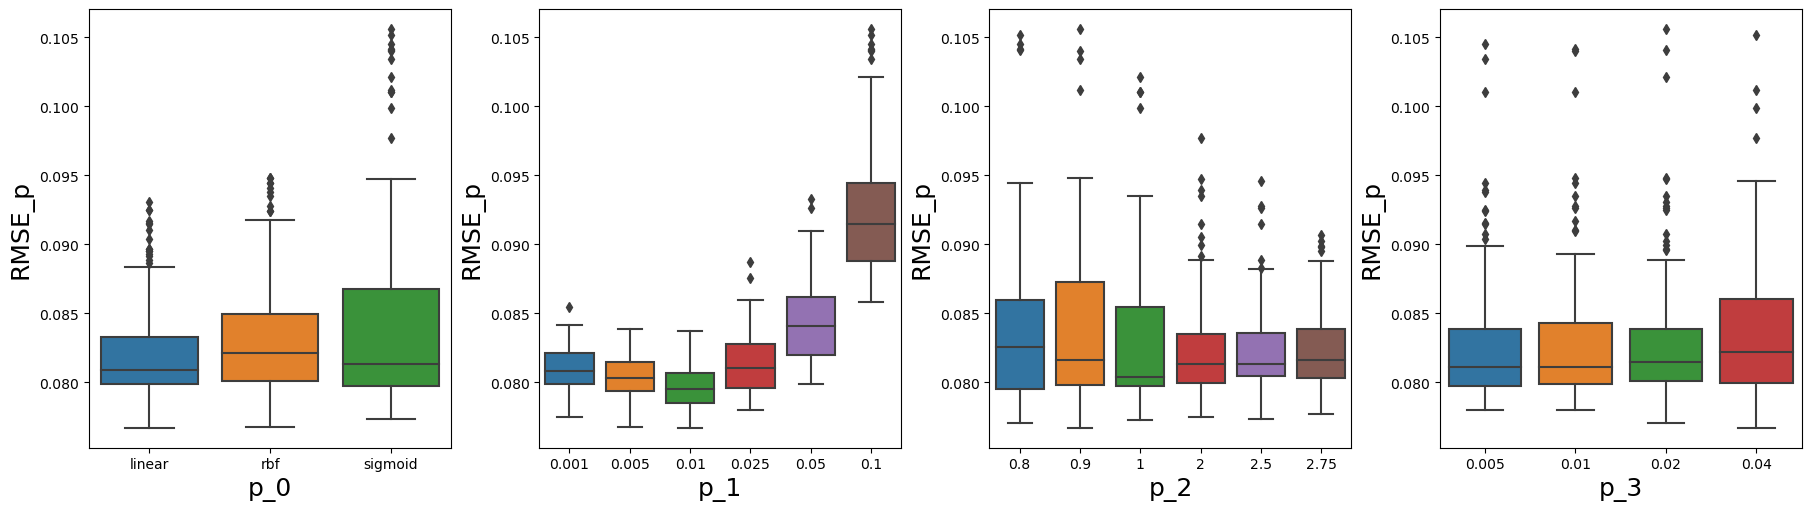

In [10]:
ms = mt.model_training().train_model(cn, column_index, model, case_study)

In [11]:
print(ms)

[SVR(C=2.75, gamma='auto', tol=0.005)
 SVR(C=0.8, epsilon=0.001, gamma='auto', kernel='sigmoid', tol=0.04)
 SVR(C=2.5, epsilon=0.01, gamma='auto', tol=0.04)
 SVR(epsilon=0.01, gamma='auto', kernel='linear', tol=0.04)]


As we can see above, the selected model is an ensamble of four support vector regressor, each of them with different hyperparameters and structure. Each model is the one minimizing the root mean squared error in each fold of the cross-validation set.

#### Testing modeling accuracy and saving the results

It is now possible to test the performance of the trained model. To do so, we perform a prediction in the test set. Such routine returns the reconstructed (i.e.: de-normalized) output signal in the training (yc_rec) and test (yv_rec) sets, as well as training (eps_c) and test (eps_v) error, and residuals (res).

In [12]:
yc_rec, yv_rec, eps_c, eps_v, res = mte.model_testing().test_model(ms, cn, vn, column_index, mn, mX, model, period)

In case we are interested in some further postprocessing, we can save the results in the .csv format in the output folder

In [13]:
yr, yo, vs, cs = pp.postprocess().save_forecasts(yc_rec, yv_rec, c, v, si, 0, n_v, period, model, case_study)

#### Postprocessing

We can now generate a visual assestment of the modeling predicting abilities, by means of a time series plot and a QQ plot. The time series plot can be used for analyzing the evolution with time and through event of the forecasting ability, and provides a comparison of training vs test performance. The QQ plot allows the identification of error magnitude vs signal magnitude, and to qualitative assess overfitting by compating training and test behavior.

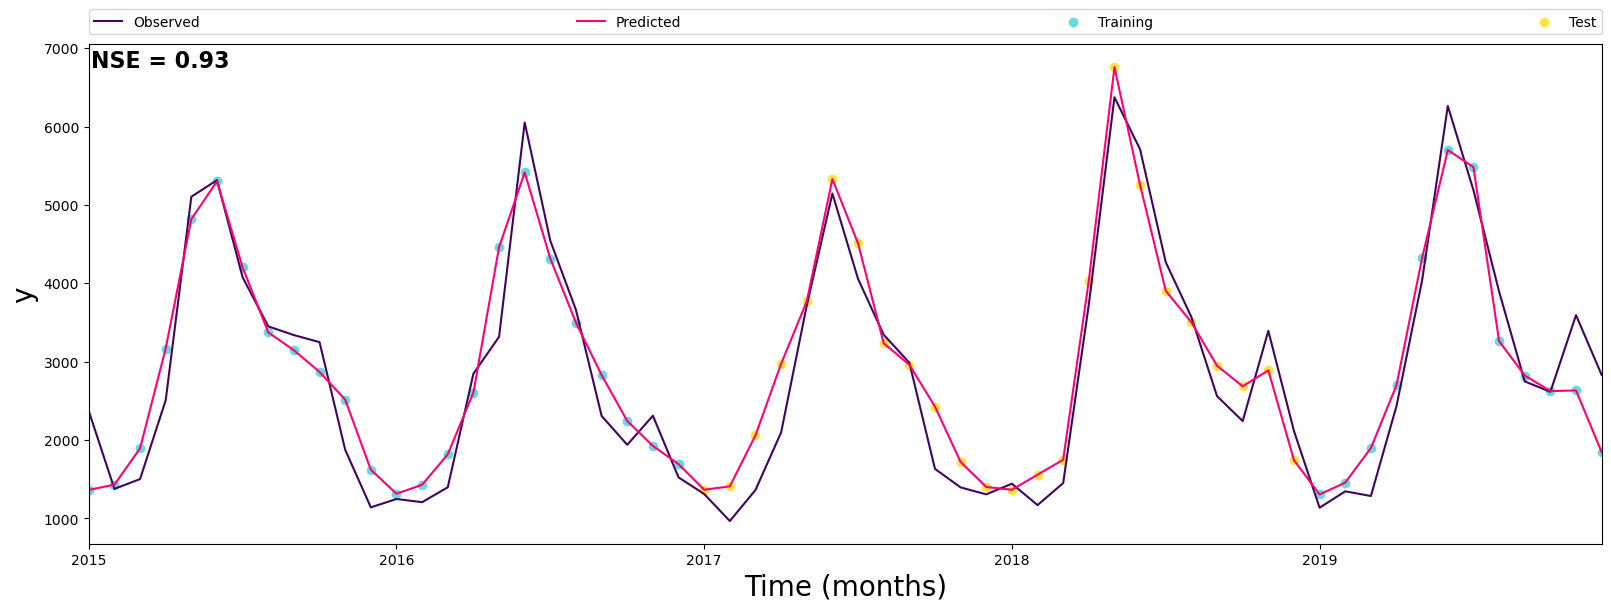

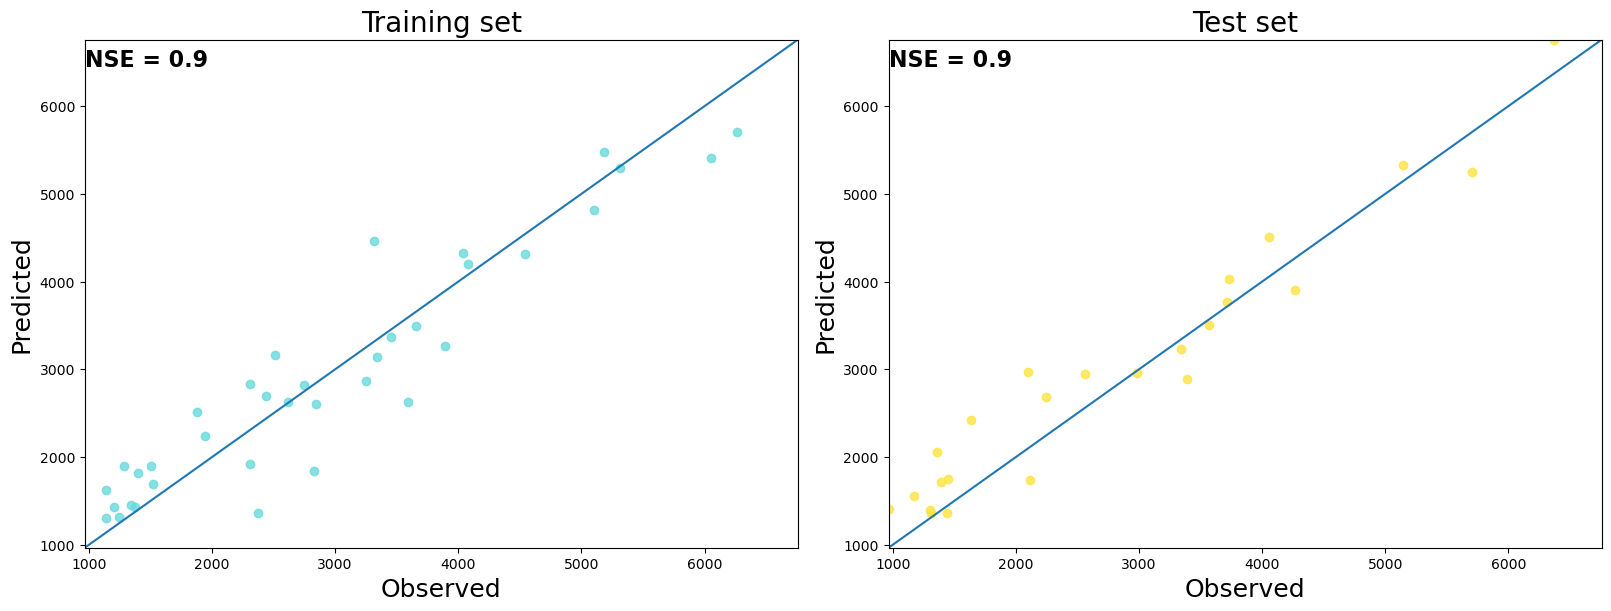

In [14]:
pp.postprocess().plot_forecasts(yr, yo, vs, cs, 0, period, model,
                                            case_study,
                                            start,
                                            end)

#### Saving the results as a python object

In order to perform further analysis (i.e.: running the model with different scenarios), we can save a result object including the main variables involved in the modeling process.

In [15]:
# Initialize and create an empty object
class Object(object):
            pass
        
results = Object()

# Fill the 'results' class
results.calibration_error = eps_c
results.validation_error = eps_v
results.columns_selected = column_index
results.models = ms
        
# Save as pkl element
fpt = os.path.join('output', case_study, 'results.pkl')
with open(fpt, 'wb') as f:
    dill.dump(results, f)

The process creates a .pkl file in the output/case_study folder, which can be loaded at any time for further analysis.